In [206]:
!pip install torch torchvision opencv-python av ipython

In [207]:
from typing import Optional
from decord import VideoReader, cpu
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from model import VJEPA
from finetune_VJEPA import VJEPA_FT
from finetune_TRJEPA import TRJEPA_FT

# Load Video and create a stacked image tensor

In [208]:
FRAMES_PER_CLIP: int = 8
VIDEO_PATH: str = (
    "E:/ahmad/kinetics-dataset/extrasmall/val/part_0/-_3E3GBXAUc_000010_000020.mp4"
)

In [209]:
def render_tensor_as_frames(tensor):
    """
    Render a tensor of shape [1, channels, frames, height, width] as frames in the notebook.

    Args:
        tensor: Input tensor with shape [1, channels, frames, height, width].
    """
    # Remove the batch dimension
    tensor = tensor.squeeze(0)  # Shape: [channels, frames, height, width]
    tensor = tensor.cpu()

    # Display each frame
    for i in range(tensor.shape[1]):
        frame = tensor[:, i, :, :]
        # Normalize the frame
        original_frame = frame - frame.min()  # Shift the minimum value to 0
        original_frame = original_frame / original_frame.max()  # Normalize to [0, 1]
        original_frame = original_frame * 255  # Scale to [0, 255]
        original_frame_image = original_frame.permute(1, 2, 0).byte()
        original_pil_image = Image.fromarray(
            original_frame_image.numpy()
        )  # Convert to PIL Image

        # Plot the frame
        plt.figure(figsize=(5, 5))
        plt.imshow(original_pil_image)
        plt.title(f"Frame {i+1}")
        plt.axis("off")
        plt.show()

In [210]:
def load_video_with_decord(video_path, transform, max_frames=None):
    vr = VideoReader(video_path, ctx=cpu(0))

    # Extract frames as a list of numpy arrays
    frames = [vr[i].asnumpy() for i in range(len(vr))[:max_frames]]

    # Convert the list of numpy arrays to a single numpy array
    frames = np.stack(frames)  # Shape: [frames, height, width, channels]

    # Convert to PyTorch tensor, reorder dimensions, and normalize
    frames = (
        torch.tensor(frames).permute(0, 3, 1, 2).float() / 255.0
    )  # [frames, channels, height, width]

    # Apply transform to each frame
    transformed_frames = torch.stack(
        [transform(frame) for frame in frames]
    )  # [frames, channels, height, width]

    # Add batch dimension and reorder to [batch_size, channels, frames, height, width]
    return transformed_frames.unsqueeze(0).permute(0, 2, 1, 3, 4)

In [211]:
# Define transforms
def make_transforms(
    random_horizontal_flip,
    random_resize_aspect_ratio,
    random_resize_scale,
    reprob,
    auto_augment,
    motion_shift,
    crop_size,
):
    transforms = [
        T.Resize((crop_size, crop_size)),  # Resize to (crop_size, crop_size)
        T.RandomHorizontalFlip(
            p=0.5 if random_horizontal_flip else 0.0
        ),  # Horizontal flip
        T.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalization
    ]
    return T.Compose(transforms)

In [212]:
transform = make_transforms(
    random_horizontal_flip=True,
    random_resize_aspect_ratio=[3 / 4, 4 / 3],
    random_resize_scale=[0.3, 1.0],
    reprob=0.0,
    auto_augment=False,
    motion_shift=False,
    crop_size=224,
)

In [213]:
# Load video and apply transforms
original_video = load_video_with_decord(
    video_path=VIDEO_PATH, transform=transform, max_frames=FRAMES_PER_CLIP
)
print(f"Tensor shape: {original_video.shape}")

Tensor shape: torch.Size([1, 3, 8, 224, 224])


## Visualise Video

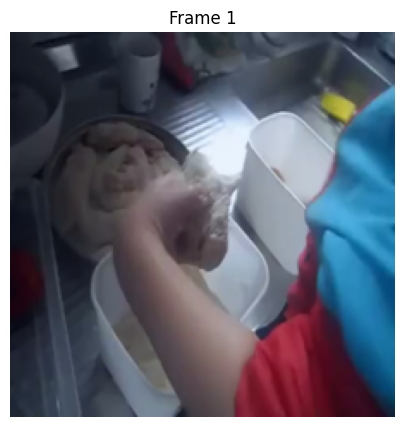

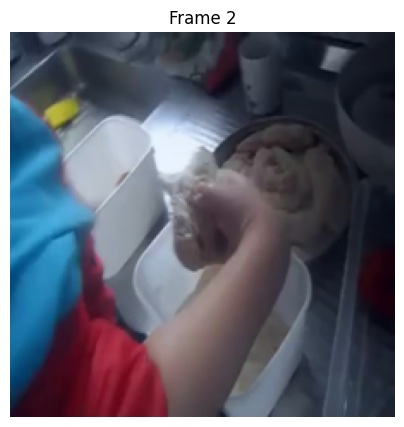

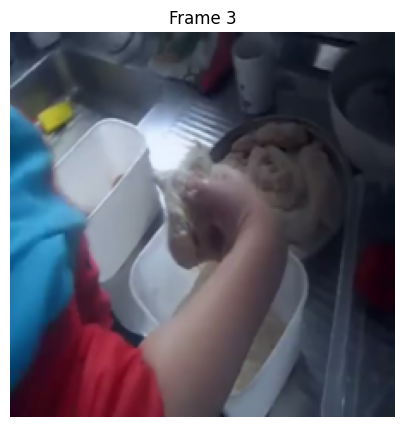

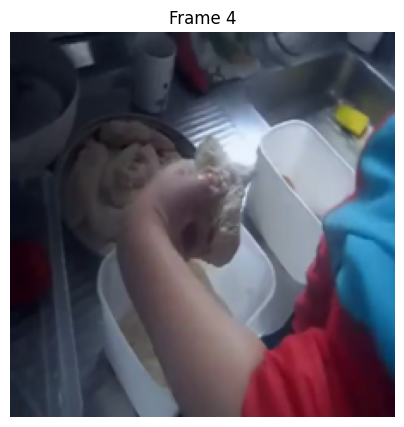

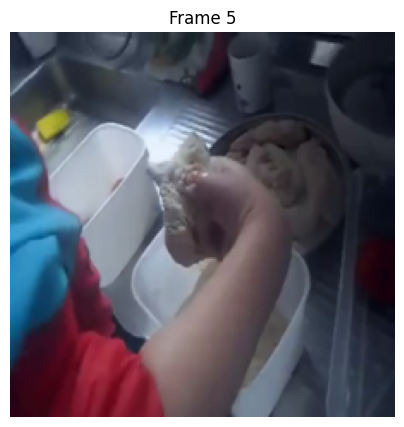

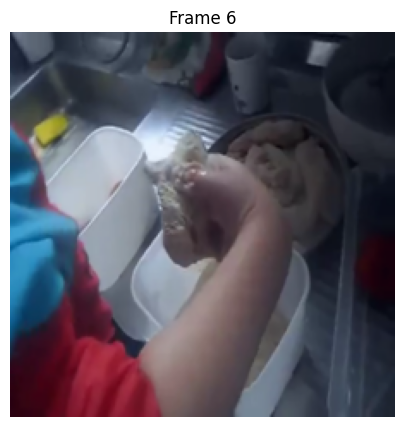

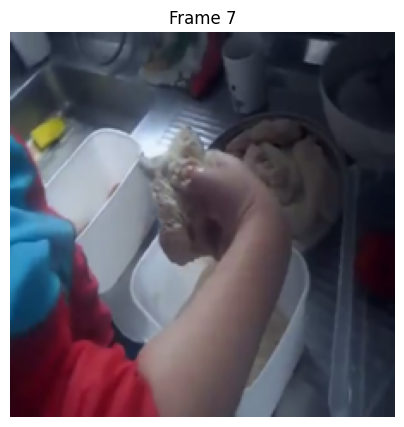

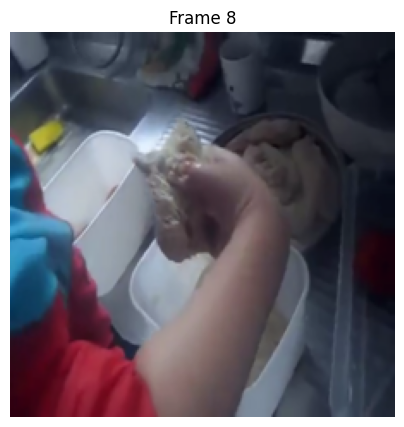

In [214]:
render_tensor_as_frames(original_video)

## Create and Visualise Stacked Image

In [215]:
##############################
# Get first frame and stack
##############################
x = original_video[:, :, 0:1, :, :]  # Get first frame and stack
stacked_img = x.repeat(1, 1, FRAMES_PER_CLIP, 1, 1)
stacked_img.shape

torch.Size([1, 3, 8, 224, 224])

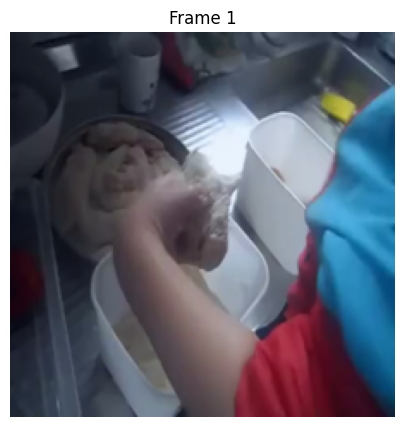

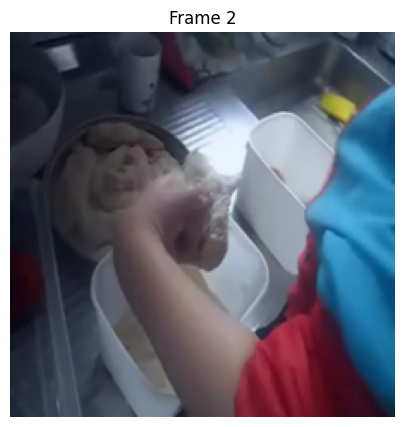

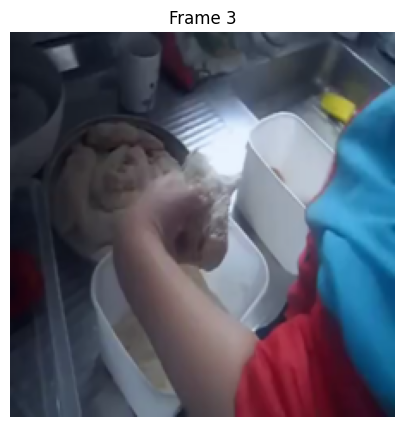

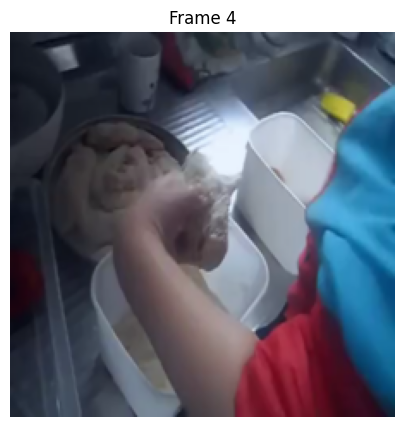

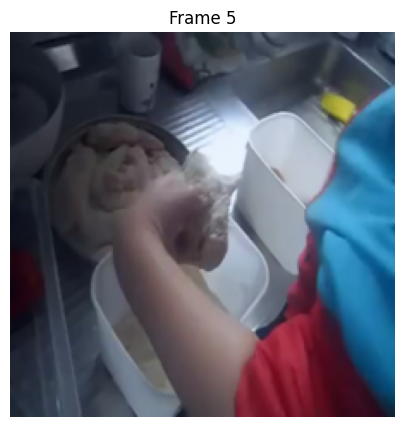

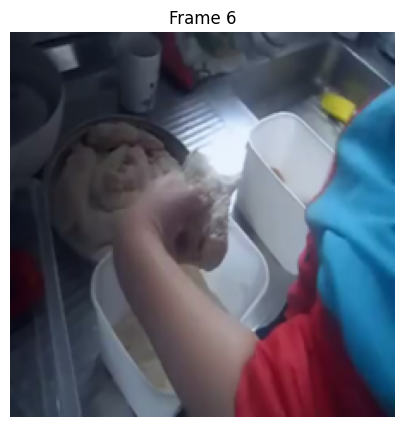

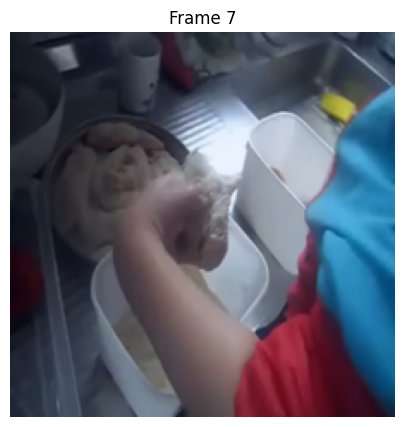

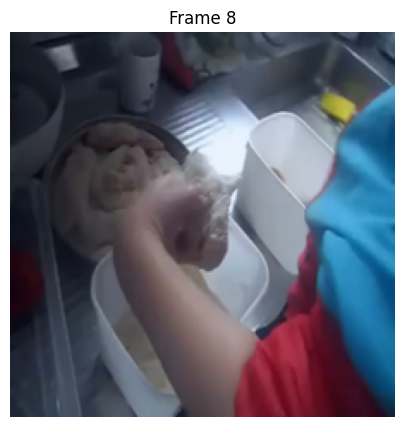

In [216]:
render_tensor_as_frames(stacked_img)

# Load Pretrain TRJEPA and Finetune TRJEPA model

In [217]:
##############################
# Load Pretrained TRJEPA model
##############################
# model = VJEPA.load_from_checkpoint(
#     "D:/MDX/Thesis/new-jepa/jepa/lightning_logs/v-jepa/pretrain/static_scene/version_6/checkpoints/epoch=2-step=90474.ckpt"
# )
model = VJEPA(lr=1e-3, num_frames=FRAMES_PER_CLIP, testing_purposes_only=True)

finetune_vjepa_path: Optional[str] = None
finetune_vjepa_model: Optional[VJEPA_FT] = None

if finetune_vjepa_path is not None:
    finetune_vjepa_model = VJEPA_FT.load_from_checkpoint(finetune_vjepa_path)

self.pos_embedding.shape=torch.Size([1, 2, 196, 64])


In [218]:
##############################
# Load Finetuned TRJEPA model
##############################
finetune_model = TRJEPA_FT(
    vjepa_model=model,
    finetune_vjepa_model=finetune_vjepa_model,
    frame_count=FRAMES_PER_CLIP,
)

finetune_trjepa_path: Optional[str] = None
if finetune_trjepa_path is not None:
    finetune_model = TRJEPA_FT.load_from_checkpoint(finetune_trjepa_path)

c:\Users\ahmad\.conda\envs\thesis\Lib\site-packages\pytorch_lightning\utilities\parsing.py:208: Attribute 'vjepa_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['vjepa_model'])`.


# Pass Stacked image tensor through model and visualise

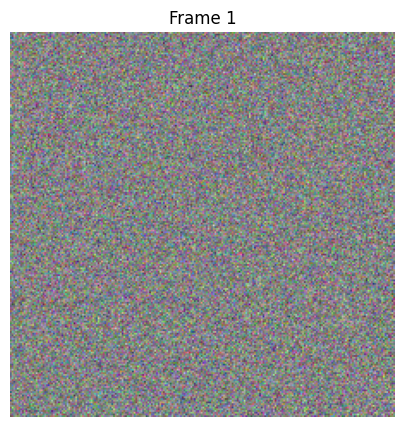

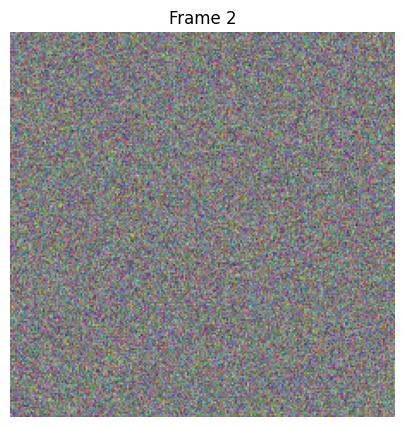

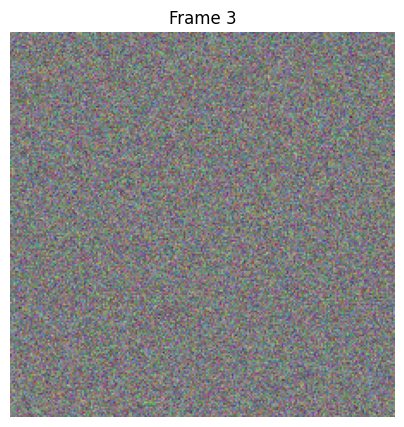

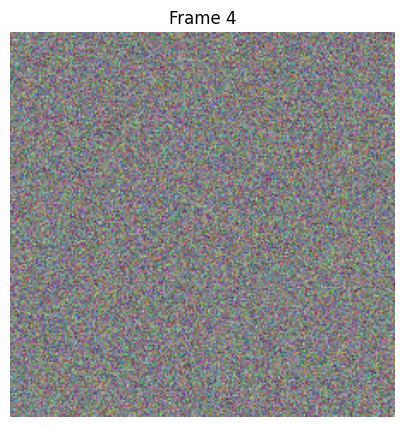

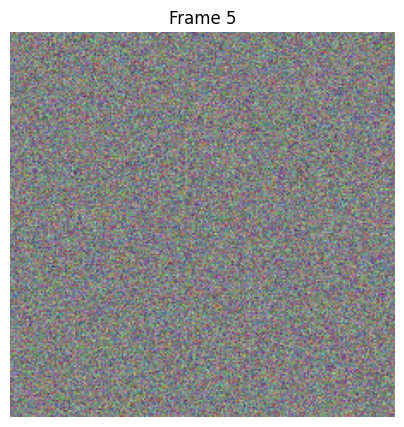

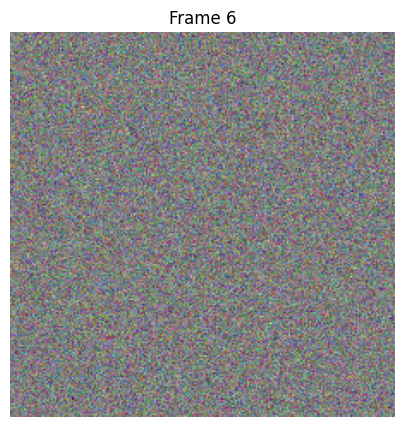

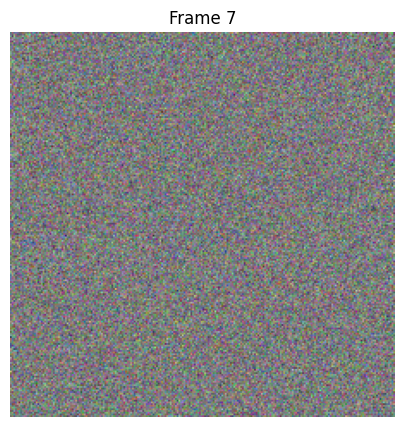

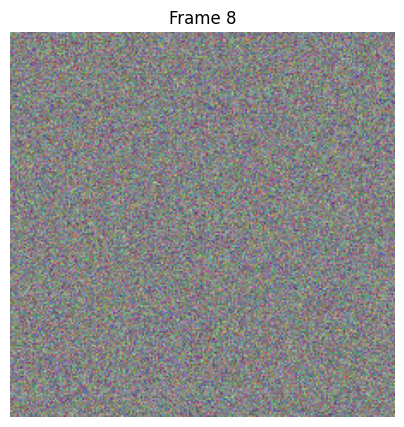

In [219]:
result = finetune_model(x=stacked_img, random_t=0)
render_tensor_as_frames(tensor=result)

## Caluclate Loss and accuracy

In [220]:
criterion = nn.MSELoss()
loss = criterion(result, original_video)  # calculate loss
accuracy = (result.argmax(dim=1) == original_video.argmax(dim=1)).float().mean()
print(f"Loss={loss} Accuracy={accuracy}")

Loss=1.5242279767990112 Accuracy=0.33310994505882263
